### EDA and Data Visualizations

In [99]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import surprise
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split, GridSearchCV
from surprise.prediction_algorithms import knns, SVD, SVDpp
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy

In [100]:
movies = pd.read_csv("data/movies.csv")
links = pd.read_csv("data/links.csv")
ratings = pd.read_csv("data/ratings.csv")
tags = pd.read_csv("data/tags.csv")

In [101]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [102]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [103]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [104]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [105]:
# def explode(df, lst_cols, fill_value='', preserve_index=False):
#     # make sure `lst_cols` is list-alike
#     if (lst_cols is not None
#         and len(lst_cols) > 0
#         and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
#         lst_cols = [lst_cols]
#     # all columns except `lst_cols`
#     idx_cols = df.columns.difference(lst_cols)
#     # calculate lengths of lists
#     lens = df[lst_cols[0]].str.len()
#     # preserve original index values    
#     idx = np.repeat(df.index.values, lens)
#     # create "exploded" DF
#     res = (pd.DataFrame({
#                 col:np.repeat(df[col].values, lens)
#                 for col in idx_cols},
#                 index=idx)
#              .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
#                             for col in lst_cols}))
#     # append those rows that have empty lists
#     if (lens == 0).any():
#         # at least one list in cells is empty
#         res = (res.append(df.loc[lens==0, idx_cols], sort=False)
#                   .fillna(fill_value))
#     # revert the original index order
#     res = res.sort_index()
#     # reset index if requested
#     if not preserve_index:        
#         res = res.reset_index(drop=True)
#     return res

In [106]:
# movies.genres = movies.genres.str.split('|')
# df = explode(movies, ['genres'])
# df.head()

In [107]:
# df = ratings.merge(df,on='movieId', how='left')

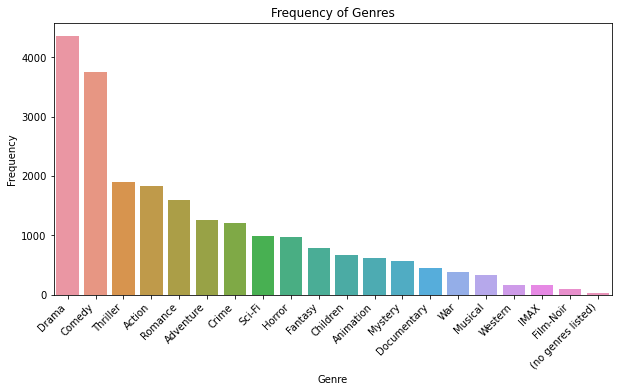

In [108]:
# visualization for frequency of each genre
fig_dims=(10,5)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(y=df.genres.value_counts(), x=df.genres.value_counts().index, ax = ax)
ax.set(xlabel="Genre", ylabel = "Frequency")
ax.set_title("Frequency of Genres")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [109]:
# splitting genres and breaking them out of list
# also put them into dummie variables
movies = movies.join(pd.get_dummies(movies.genres.str.split('|').apply(pd.Series).stack()).sum(level=0))

In [110]:
movies.head()

,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [111]:
import time
ratings['timestamp'] = ratings['timestamp'].apply(lambda x: time.strftime('%Y', time.localtime(x)))
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,2000
1,1,3,4.0,2000
2,1,6,4.0,2000
3,1,47,5.0,2000
4,1,50,5.0,2000


In [112]:
data = ratings.merge(movies,on='movieId', how='left')
data = data.merge(tags, on='movieId', how='left')
movies = data.merge(links, on='movieId', how='left')

In [113]:
# do we take year out of title?
movies
movies.drop(columns = ['timestamp_x', 'genres', 'userId_y', 'timestamp_y'], inplace = True)

In [39]:
movies.rename(columns = {'userId_x': 'userid', '(no genres listed)':'no_genres_listed'})

,userid,movieId,rating,title,no_genres_listed,Action,Adventure,Animation,Children,Comedy,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,tag,imdbId,tmdbId
0,1,1,4.0,Toy Story (1995),0,0,1,1,1,1,...,0,0,0,0,0,0,0,pixar,114709,862.0
1,1,1,4.0,Toy Story (1995),0,0,1,1,1,1,...,0,0,0,0,0,0,0,pixar,114709,862.0
2,1,1,4.0,Toy Story (1995),0,0,1,1,1,1,...,0,0,0,0,0,0,0,fun,114709,862.0
3,1,3,4.0,Grumpier Old Men (1995),0,0,0,0,0,1,...,0,0,1,0,0,0,0,moldy,113228,15602.0
4,1,3,4.0,Grumpier Old Men (1995),0,0,0,0,0,1,...,0,0,1,0,0,0,0,old,113228,15602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285757,610,168252,5.0,Logan (2017),0,1,0,0,0,0,...,0,0,0,1,0,0,0,emotional,3315342,263115.0
285758,610,168252,5.0,Logan (2017),0,1,0,0,0,0,...,0,0,0,1,0,0,0,gritty,3315342,263115.0
285759,610,168252,5.0,Logan (2017),0,1,0,0,0,0,...,0,0,0,1,0,0,0,heartbreaking,3315342,263115.0
285760,610,168252,5.0,Logan (2017),0,1,0,0,0,0,...,0,0,0,1,0,0,0,predictible plot,3315342,263115.0


In [40]:
Average_ratings = pd.DataFrame(data.groupby('title')['rating'].mean())
Average_ratings.head(10)

,rating
title,
'71 (2014),4.000000
'Hellboy': The Seeds of Creation (2004),4.000000
'Round Midnight (1986),3.500000
'Salem's Lot (2004),5.000000
'Til There Was You (1997),4.000000
'Tis the Season for Love (2015),1.500000
"'burbs, The (1989)",3.176471
'night Mother (1986),3.000000
(500) Days of Summer (2009),3.666667


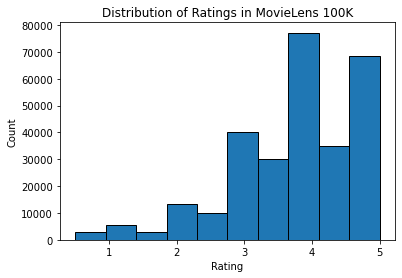

In [41]:
# plotting a histogram of ratings for movies
plt.hist(data['rating'], bins=10, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in MovieLens 100K')
plt.show()
# seems like most movies fall in the 3-4 range, not many that have low ratings (1,2)

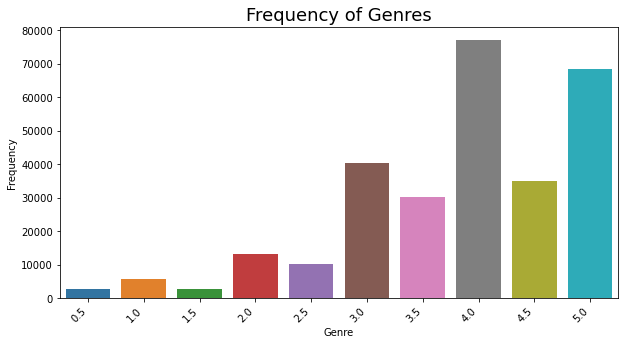

In [42]:
fig_dims=(10,5)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(y=data.rating.value_counts(), x=data.rating.value_counts().index, ax = ax)
ax.set(xlabel="Genre", ylabel = "Frequency")
ax.set_title("Frequency of Genres", size=18)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
# plt.hlines(data.rating.value_counts().mean(),  -.5 ,9.5 , colors="darkgoldenrod", label="Average Frequency") #plot average price horizontal line\
# plt.legend()
plt.show()

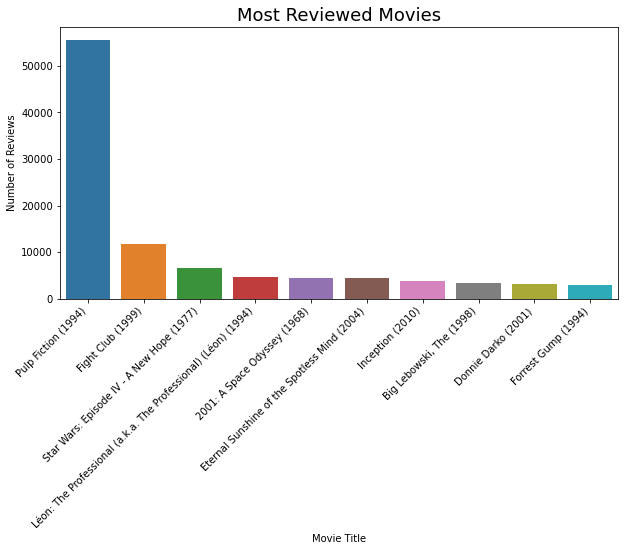

Pulp Fiction (1994)                                               0.194452
Fight Club (1999)                                                 0.041195
Star Wars: Episode IV - A New Hope (1977)                         0.022837
Léon: The Professional (a.k.a. The Professional) (Léon) (1994)    0.016290
2001: A Space Odyssey (1968)                                      0.015639
Eternal Sunshine of the Spotless Mind (2004)                      0.015586
Inception (2010)                                                  0.013011
Big Lebowski, The (1998)                                          0.011870
Donnie Darko (2001)                                               0.011062
Forrest Gump (1994)                                               0.010362
Name: title, dtype: float64

In [43]:
fig_dims=(10,5)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(y=data.title.value_counts()[:10], x=data.title.value_counts(10)[:10].index, ax = ax)
ax.set(xlabel="Movie Title", ylabel = "Number of Reviews")
ax.set_title("Most Reviewed Movies", size=18)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
# plt.hlines(data.rating.value_counts().mean(),  -.5 ,9.5 , colors="darkgoldenrod", label="Average Frequency") #plot average price horizontal line\
# plt.legend()
plt.show()
data.title.value_counts(10)[:10]

In [ ]:
df.groupby('genres')['rating'].mean().sort_values(ascending=False)

### Modeling 

In [55]:
# Split into train and test set
reader = Reader()
ratings_surprise = Dataset.load_from_df(ratings,Reader(rating_scale=(0,5)))

In [119]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,2000
1,1,3,4.0,2000
2,1,6,4.0,2000
3,1,47,5.0,2000
4,1,50,5.0,2000
...,...,...,...,...
100831,610,166534,4.0,2017
100832,610,168248,5.0,2017
100833,610,168250,5.0,2017
100834,610,168252,5.0,2017


In [53]:
ratings.drop(columns = 'timestamp', inplace = True)

In [57]:
ratings_surprise

In [58]:
trainset, testset = train_test_split(ratings_surprise, test_size=0.2)

In [60]:
print(len(testset))
print(testset[0])

20168
(287, 2804, 3.0)


In [71]:
sim_cos = {'name':'cosine','user_based':True}
basic_knn = knns.KNNBasic(sim_options=sim_cos)
basic_knn.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [72]:
predictions = basic_knn.test(testset)

In [73]:
accuracy.rmse(predictions)

RMSE: 0.9740


0.9739772952706238

In [74]:
print(accuracy.rmse(predictions))

RMSE: 0.9740
0.9739772952706238


In [75]:
sim_pearson = {'name':'pearson', 'user_based':True}
basic_pearson = knns.KNNBasic(sim_options=sim_pearson)
basic_pearson.fit(trainset)
predictions = basic_pearson.test(testset)
print(accuracy.rmse(predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9758
0.9757762867380319


In [76]:
knn_means = knns.KNNWithMeans(sim_options=sim_cos)
knn_means.fit(trainset)
predictions = knn_means.test(testset)
print(accuracy.rmse(predictions))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9047
0.9047264441034756


In [77]:
knn_baseline = knns.KNNBaseline(sim_options=sim_cos)
knn_baseline.fit(trainset)
predictions = knn_baseline.test(testset)
print(accuracy.rmse(predictions))

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8812
0.8811870858396551


In [79]:
from surprise.prediction_algorithms import SVD
from surprise.model_selection import GridSearchCV

In [78]:
param_grid = {'n_factors':[20, 100],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs_model = GridSearchCV(SVD,param_grid=param_grid,n_jobs = -1,joblib_verbose=5)
gs_model.fit(ratings_surprise)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.3min finished


In [86]:
print(gs_model.best_score)
gs_model.best_params

{'rmse': 0.8905369569694302, 'mae': 0.6889889077364265}


{'rmse': {'n_factors': 20, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4},
 'mae': {'n_factors': 20, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}}

In [87]:
# matrix factorization
svd = SVD(n_factors=20, n_epochs=10, lr_all=0.005, reg_all=0.4)
svd.fit(trainset)
predictions = svd.test(testset)
print(accuracy.rmse(predictions))

RMSE: 0.8934
0.8934230670749288


In [117]:
user_1_prediction = svd.predict(3, 1)
user_1_prediction

Prediction(uid=3, iid=1, r_ui=None, est=3.0181742323894083, details={'was_impossible': False})